# ML Titanic Age Regressor
This notebook develop regression model for age prediction to fill na values in original dataset

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [178]:
titanic_data = pd.read_csv("../../data/train.csv")
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [179]:
print("Missing values:")
titanic_data.isna().sum()

Missing values:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Data preprocessing

Some of the Passengers have a long name because of their high social status.

In [180]:
#count number of words by spaces in names
name_words_count = titanic_data.Name.apply(lambda x: x.count(" "))
titanic_data["Name"] = name_words_count

#Encoding for sex (1 - male, 0 - female)
titanic_data["Sex"]= titanic_data.Sex.apply(lambda x: x == "male")

#drop tickets number and cabins from dataset
titanic_data = titanic_data.drop(["Ticket","Cabin"], axis=1)


# EDA

## Distributions

Text(0.5, 1.0, 'Words in Passengers names distribution')

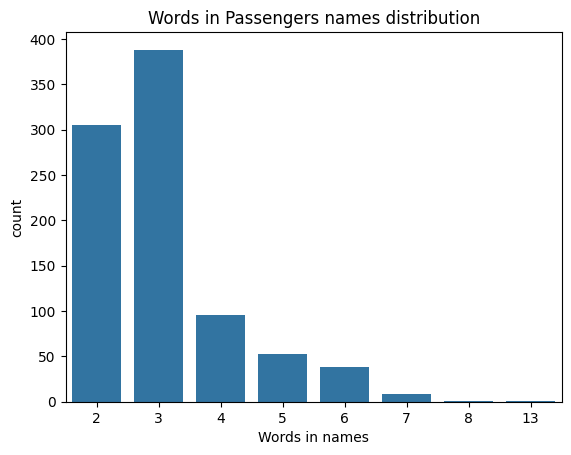

In [181]:
sns.countplot(titanic_data, x="Name")
plt.xlabel("Words in names")
plt.title("Words in Passengers names distribution")

Text(0.5, 1.0, 'Passengers age distribution')

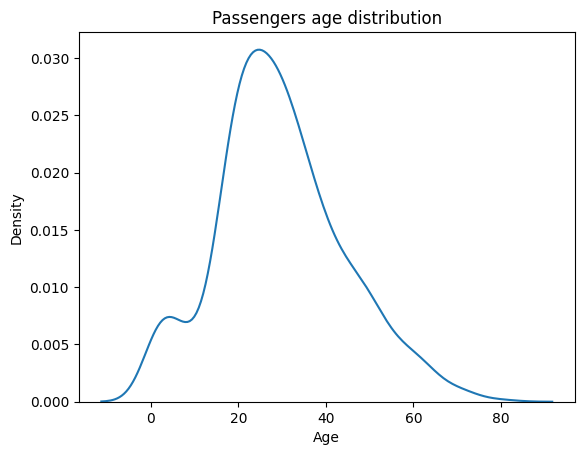

In [182]:
sns.kdeplot(titanic_data,x="Age")
plt.title("Passengers age distribution")

Text(0.5, 1.0, 'Passengers fare distribution')

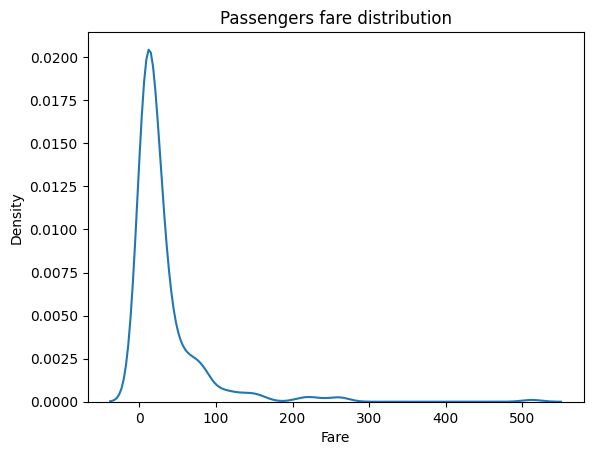

In [183]:
sns.kdeplot(titanic_data,x="Fare")
plt.title("Passengers fare distribution")

# Creating Model
RandomForestRegressor was choosed for age prediction because of providing predictions by mean in groups

In [184]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

In [185]:
#Creating test dataset
titanic_test = pd.read_csv("../../data/test.csv")

#count number of words by spaces in names
name_words_count = titanic_test.Name.apply(lambda x: x.count(" "))
titanic_test["Name"] = name_words_count

#Encoding for sex (1 - male, 0 - female)
titanic_test["Sex"]= titanic_test.Sex.apply(lambda x: x == "male")

#drop tickets number and cabins from dataset
titanic_test = titanic_test.drop(["Ticket","Cabin"], axis=1)

In [186]:
#One hot encoding
titanic_data = pd.get_dummies(titanic_data)
titanic_test = pd.get_dummies(titanic_test)

#set indexes in dataframes
titanic_data = titanic_data.set_index("PassengerId")
titanic_test = titanic_test.set_index("PassengerId")

#Delete NA age from subsets
titanic_data =titanic_data[-titanic_data["Age"].isna()]
titanic_test = titanic_test[-titanic_test["Age"].isna()]

#Fill Embarked NA with 0
titanic_data.fillna(0)
titanic_test.fillna(0)

X_train = titanic_data.drop(["Age","Survived"], axis=1)
y_train = titanic_data["Age"]

X_test = titanic_test.drop("Age", axis=1)
y_test = titanic_test["Age"]

In [187]:
# Params grid functions

def first_grid():
    """Compute first raw search grid"""
    rgrs = RandomForestRegressor(random_state=42)

    parameters = {
        "n_estimators":range(1,600,200),
        "max_depth":range(1,100,25),
        "min_samples_split": range(25,100,25),
        "min_samples_leaf": range(25,100,25)
    }

    search = GridSearchCV(rgrs,param_grid=parameters, n_jobs=-1, verbose=True)
    search.fit(X_test,y_test)
    return search

def second_grid():
    """Compute second raw search grid"""
    rgrs = RandomForestRegressor(random_state=42)

    parameters = {
        "n_estimators":range(50,250,50),
        "max_depth":range(5,25,5),
        "min_samples_split": range(5,30,5),
        "min_samples_leaf": range(5,30,5)
    }

    search = GridSearchCV(rgrs,param_grid=parameters, n_jobs=-1, verbose=True)
    search.fit(X_test,y_test)
    return search

def third_grid():
    """Compute second raw search grid"""
    rgrs = RandomForestRegressor(random_state=42)

    parameters = {
        "n_estimators":range(10,60,10),
        "max_depth":range(1,5),
        'min_samples_leaf': range(2,10),
        'min_samples_split': range(10,19),
    }

    search = GridSearchCV(rgrs,param_grid=parameters, n_jobs=-1, verbose=True)
    search.fit(X_test,y_test)
    return search

def final_grid():
    """Compute second raw search grid"""
    rgrs = RandomForestRegressor(random_state=42)

    parameters = {
        "n_estimators":range(20,30),
    }

    search = GridSearchCV(rgrs,param_grid=parameters, n_jobs=-1, verbose=True)
    search.fit(X_test,y_test)
    return search

In [188]:
# print(first_grid().best_params_ )
first_prm = {
    'max_depth': 26,
    'min_samples_leaf': 25,
    'min_samples_split': 25,
    'n_estimators': 201
}

# print(second_grid().best_params_)
second_prm = {
    'max_depth': 5,
    'min_samples_leaf': 5,
    'min_samples_split': 15,
    'n_estimators': 50
    }

# print(third_grid().best_params_)
third_prm = { 
    'max_depth': 4,
    'min_samples_leaf': 5,
    'min_samples_split': 17,
    'n_estimators': 20
    }

# print(final_grid().best_params_)
parameters = { #Final choosed parameters
    'max_depth': 4,
    'min_samples_leaf': 5,
    'min_samples_split': 17,
    'n_estimators': 25
    }

In [189]:
#Creating model
rgrs = RandomForestRegressor(random_state=42, **parameters)
rgrs.fit(X_train,y_train)

RandomForestRegressor(max_depth=4, min_samples_leaf=5, min_samples_split=17,
                      n_estimators=25, random_state=42)

## Features Interpretation

Text(0.5, 1.0, 'Feature importances')

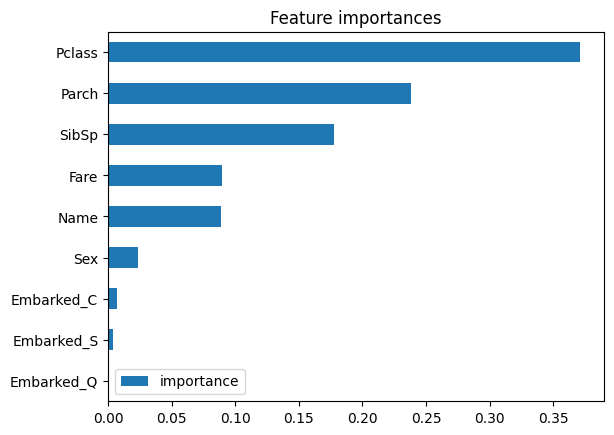

In [195]:
features = pd.DataFrame(rgrs.feature_importances_, index=X_train.columns, columns=['importance'])
features.sort_values("importance").plot(kind="barh")
plt.title("Feature importances")

## Errors visualization

In [191]:
# Prediction
y_pred = rgrs.predict(X_test)

# Mean error
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean absolute prediction error (MAE): {mae:.2f} years")
print(f"Mean absolute error median sample (MAE): {(abs(y_test - y_test.median())).mean():.2f} years")
print(f"Mean absolute error mean sample (MAE): {(abs(y_test - y_test.mean())).mean():.2f} years")

Mean absolute prediction error (MAE): 9.29 years
Mean absolute error median sample (MAE): 10.94 years
Mean absolute error mean sample (MAE): 11.17 years


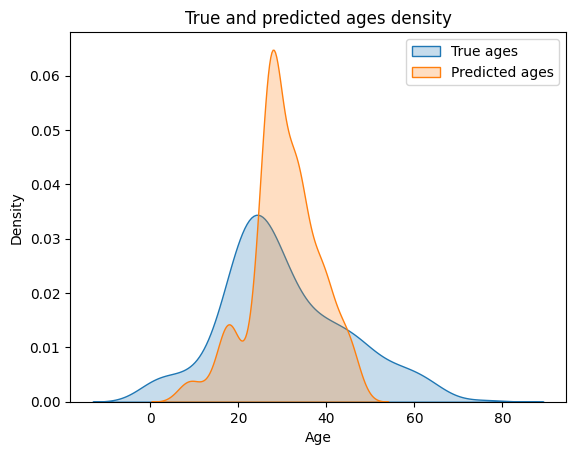

In [192]:
true_pred = pd.DataFrame({
    "True":y_test,
    "Predicted":y_pred,
    'Error': abs(y_test - y_pred)
})

sns.kdeplot(true_pred,x="True", label = "True ages", fill=True)
sns.kdeplot(true_pred,x="Predicted", label = "Predicted ages" , fill=True)

plt.title("True and predicted ages density")
plt.xlabel("Age")
plt.legend()